## 1.Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import joblib

## 2.Data Loading and Understanding

In [2]:
### Loading Dataset
df = pd.read_csv("telecom_churn_mock_data.csv")
pd.set_option('display.max_column', None)

In [3]:
df.shape

(2000, 21)

In [4]:
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST1000,Male,0,No,No,30,Yes,Yes,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.55,2047.01,Yes
1,CUST1001,Female,0,No,Yes,11,Yes,Yes,Fiber optic,No internet service,No internet service,No,No internet service,No,No internet service,Month-to-month,Yes,Electronic check,48.08,522.42,No
2,CUST1002,Female,1,No,No,17,No,No,Fiber optic,No,Yes,No,No,Yes,No,Two year,No,Electronic check,36.56,610.07,No
3,CUST1003,Female,0,Yes,No,26,Yes,No,No,No,No,No,No,No,No,One year,Yes,Bank transfer (automatic),79.72,2159.26,No
4,CUST1004,Male,0,Yes,Yes,23,Yes,No,Fiber optic,No internet service,No,No,Yes,No,Yes,Month-to-month,Yes,Mailed check,70.42,1672.56,No


In [5]:
# Checking for missing values
df.isnull().sum()

CustomerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        20
Churn                0
dtype: int64

In [6]:
# Filling Missing Values in "TotalCharges" COlumn
df["TotalCharges"] = df["TotalCharges"].fillna(df["MonthlyCharges"] * df["Tenure"])

In [7]:
df.isnull().sum()

CustomerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        2000 non-null   object 
 1   Gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   Tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [10]:
# Dropping CustomerID as it'd not be helpful in modeling
df = df.drop("CustomerID", axis=1)

In [11]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [12]:
# Printing unique values in categorical columns
numerical_cols = ["MonthlyCharges",	"TotalCharges","Tenure"]
for i in df.columns:
    if i not in numerical_cols:
        print(i, df[i].unique())

Gender ['Male' 'Female']
SeniorCitizen [0 1]
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['Yes' 'No' 'No phone service']
InternetService ['No' 'Fiber optic' 'DSL']
OnlineSecurity ['No' 'No internet service' 'Yes']
OnlineBackup ['No' 'No internet service' 'Yes']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'No internet service' 'Yes']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'No internet service' 'Yes']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['No' 'Yes']
PaymentMethod ['Bank transfer (automatic)' 'Electronic check' 'Mailed check'
 'Credit card (automatic)']
Churn ['Yes' 'No']


In [13]:
# checking the class distribution of target column
print(df["Churn"].value_counts())

Churn
No     1354
Yes     646
Name: count, dtype: int64


### Insights
1.Customer ID removed as it is not required for modelling
2.Filled missing values using the logic
3.Class imbalance identified in the target

## 3.Exploratory Data Analysis (EDA)

In [14]:
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.151500,36.342500,65.880710,2394.136215
std,0.358625,21.029392,27.154716,1807.856694
min,0.000000,1.000000,18.000000,18.000000
25%,0.000000,18.000000,45.342500,934.712500
50%,0.000000,37.000000,65.460000,1972.770000
75%,0.000000,54.000000,84.992500,3532.675000
max,1.000000,72.000000,120.000000,8756.020000


In [15]:
# Histplot for numerical columns

def plot_histplot(df, column_name):
    
    plt.figure(figsize=(7, 3))
    sns.histplot(df[column_name], kde=True)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    
    # Vertical lines for mean and median

    plt.axvline(df[column_name].mean(), color='red', linestyle='--', label="Mean")
    plt.axvline(df[column_name].median(), color='green', linestyle = '-', label="Median" )

    plt.legend()
    plt.show()

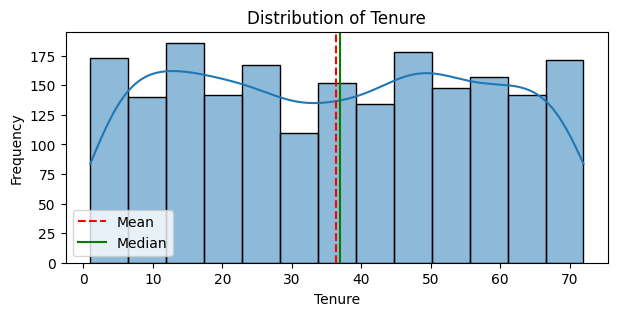

In [16]:
plot_histplot(df, "Tenure")

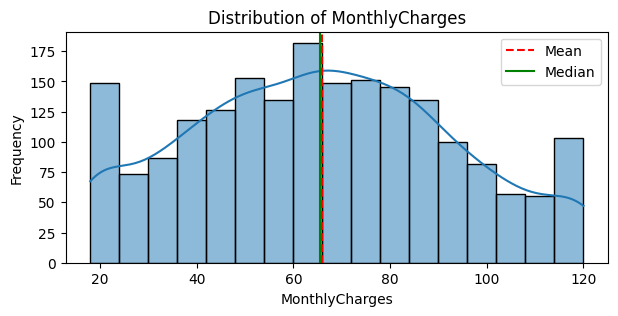

In [17]:
plot_histplot(df, "MonthlyCharges")

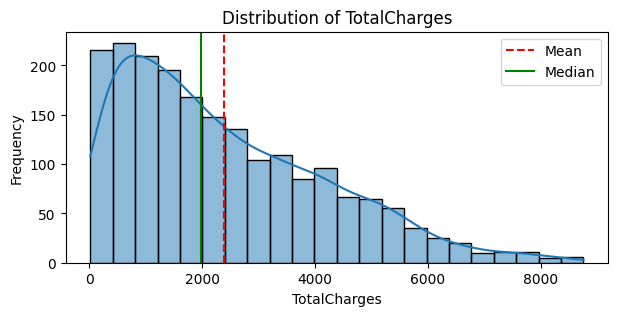

In [18]:
plot_histplot(df, "TotalCharges")

TO remove skewness of "TotalCharges", I'll apply Yeo-Johnson Transformation

In [19]:
# Removing skewness from "TotalCharges"
from sklearn.preprocessing import PowerTransformer

# Initialize Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

df['TotalCharges_Yeo'] = pt.fit_transform(df[['TotalCharges']])

print(f"Lambda used for Yeo-Johnson: {pt.lambdas_[0]}")

Lambda used for Yeo-Johnson: 0.37224513582749513


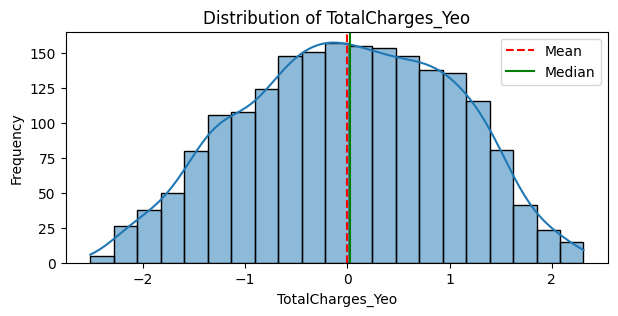

In [20]:
plot_histplot(df, "TotalCharges_Yeo")

<Axes: ylabel='TotalCharges_Yeo'>

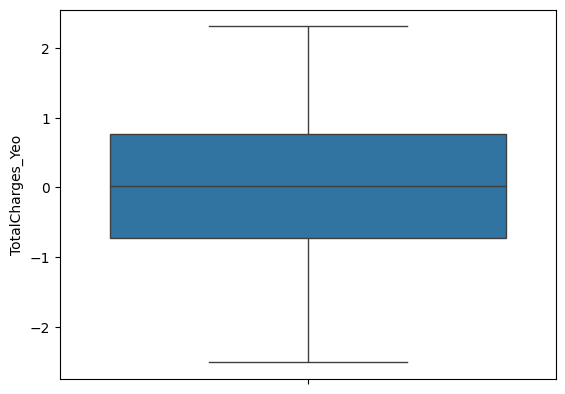

In [21]:
sns.boxplot(df["TotalCharges_Yeo"])

In [22]:
# Dropping original "TotalCharges" column
df.drop("TotalCharges", axis=1, inplace=True)

Text(0.5, 1.0, 'Boxplot of Tenure')

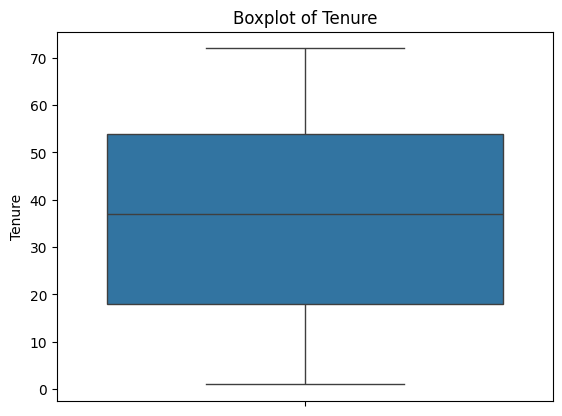

In [23]:
sns.boxplot(df["Tenure"])
plt.title("Boxplot of Tenure")

Text(0.5, 1.0, 'Boxplot of Monthly Charges')

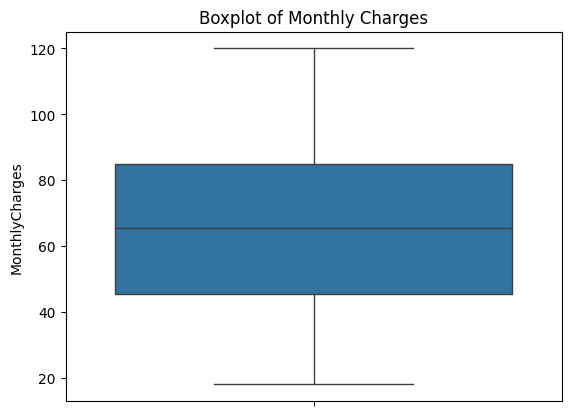

In [24]:
sns.boxplot(df["MonthlyCharges"])
plt.title("Boxplot of Monthly Charges")

<Axes: xlabel='Churn', ylabel='Count'>

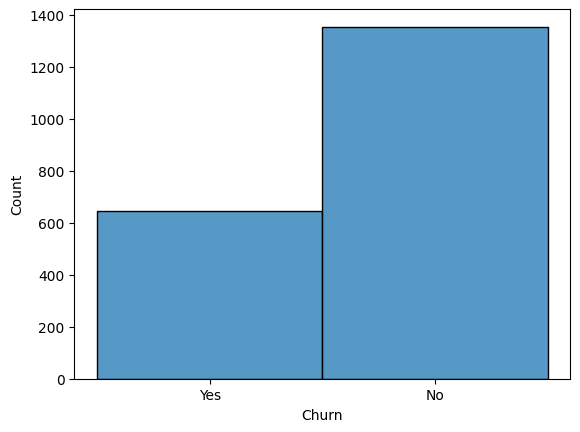

In [25]:
# Checking the distribution of Target Column
sns.histplot(data=df["Churn"])

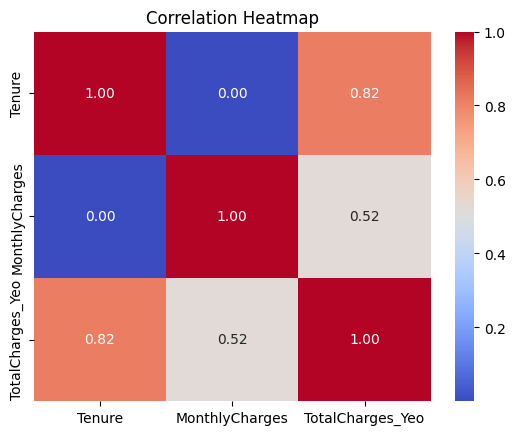

In [26]:
#  Checking correlation between numerical columns

sns.heatmap(df[["Tenure", "MonthlyCharges", "TotalCharges_Yeo"]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

There is significant corelattion between TotalCharges_Yeo and Tenure but in tree based models this doesn't affect.

#### Categorical Features Analysis

In [27]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn', 'TotalCharges_Yeo'],
      dtype='object')

In [28]:
# Extracting All Categorical Columns

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove("Churn")
cat_cols = ["SeniorCitizen"] + cat_cols
cat_cols


['SeniorCitizen',
 'Gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Countplot for all categorical columns

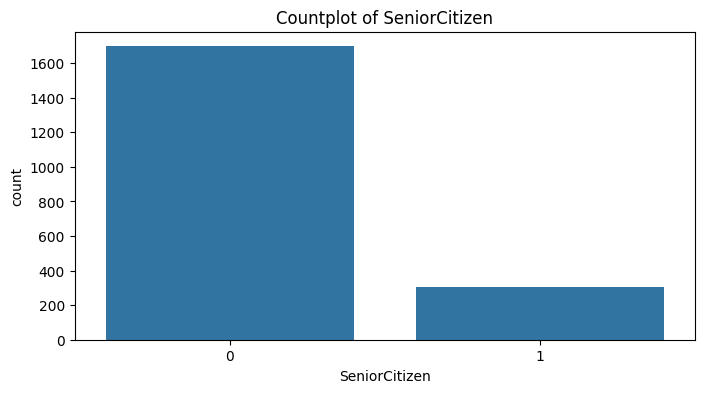

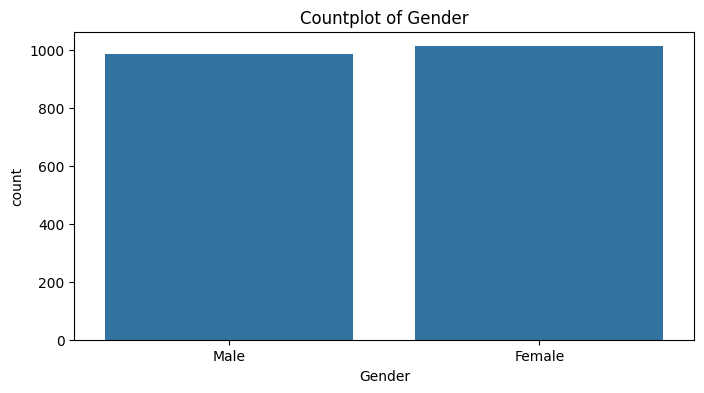

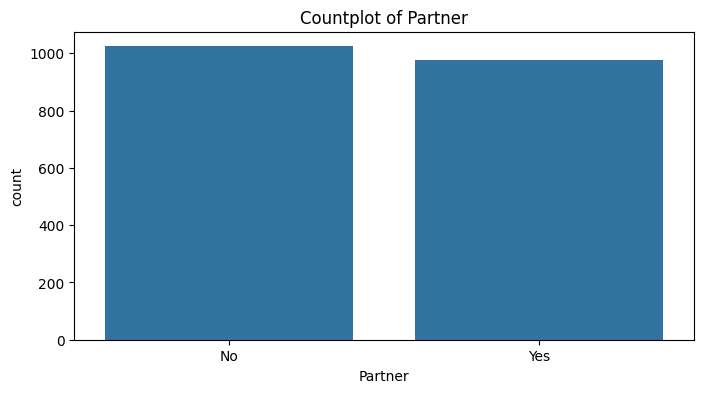

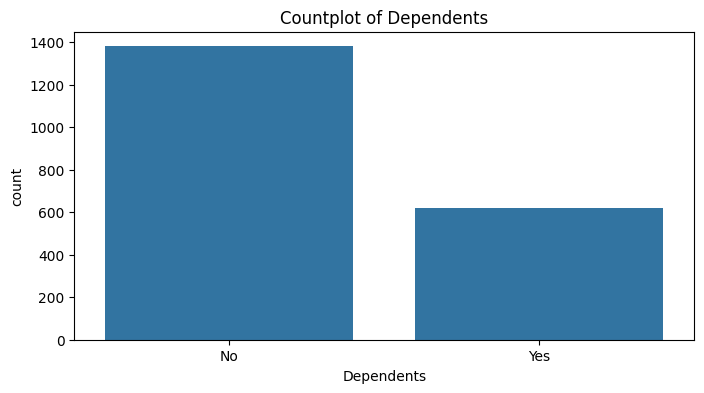

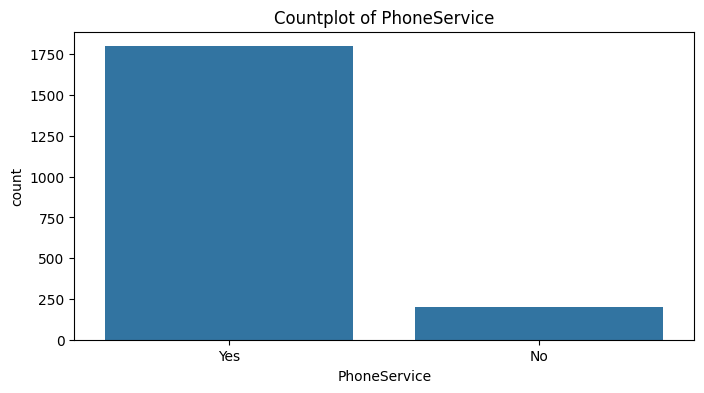

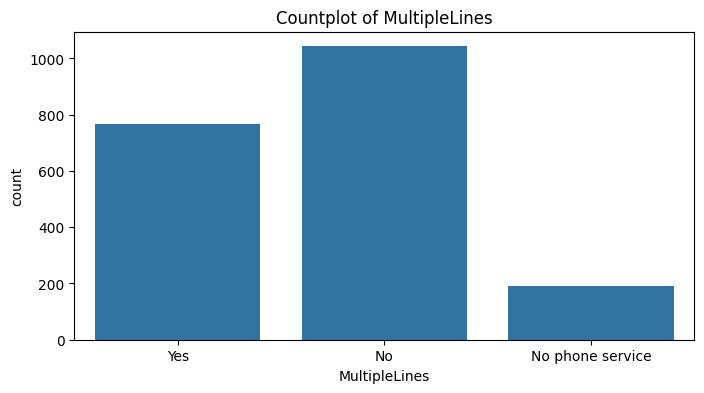

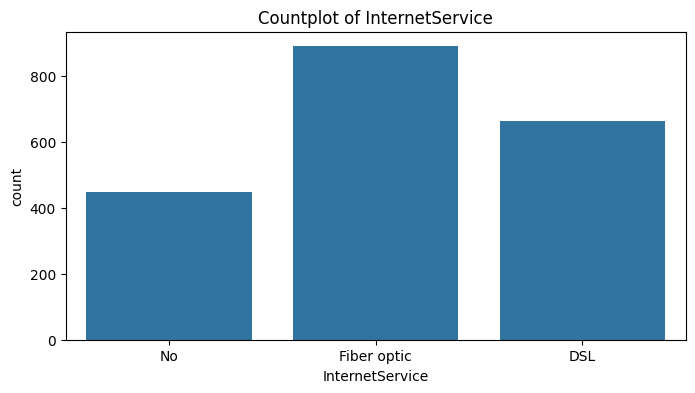

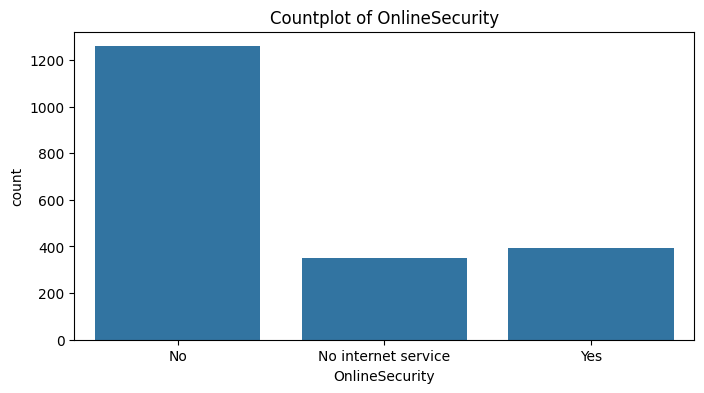

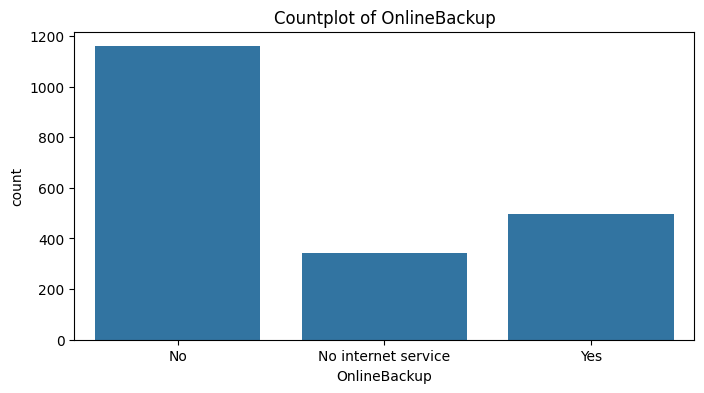

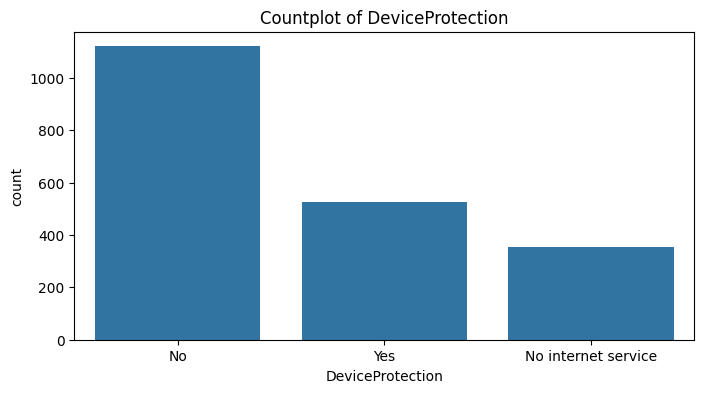

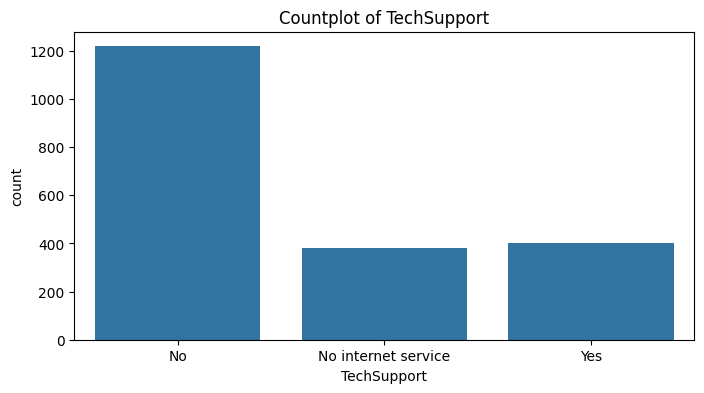

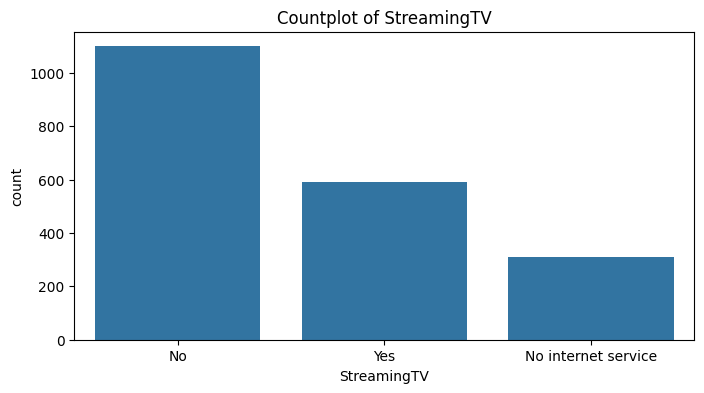

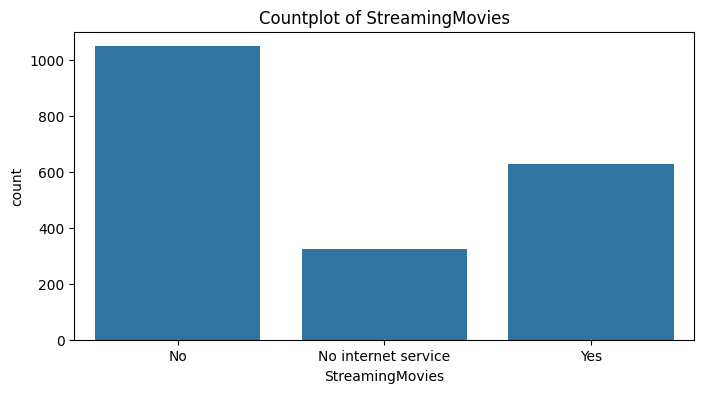

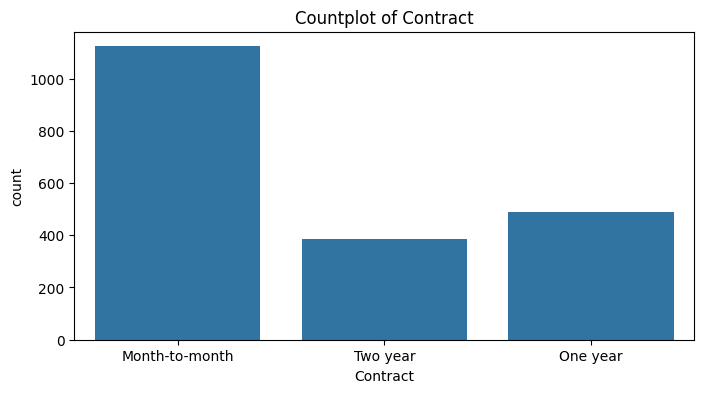

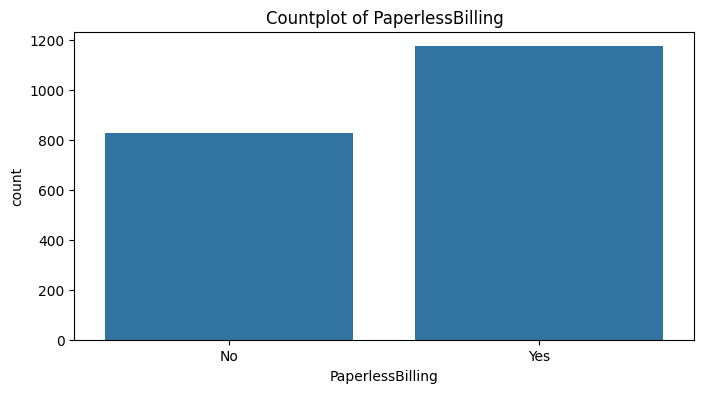

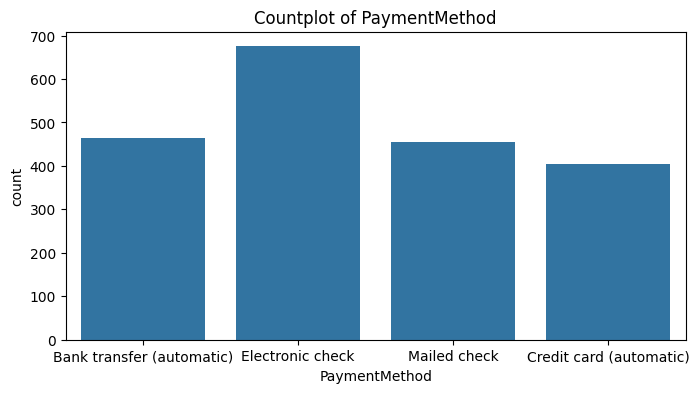

In [29]:
for i in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[i])
    plt.title(f"Countplot of {i}")
    plt.show()

##### As I am going to use Tree models and they are not affected by feature imbalance so I am letting the columns as they are.

## 4.Data Preprocessing

Label Encoding

In [30]:
df.head(3)

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalCharges_Yeo
0,Male,0,No,No,30,Yes,Yes,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.55,Yes,0.066460
1,Female,0,No,Yes,11,Yes,Yes,Fiber optic,No internet service,No internet service,No,No internet service,No,No internet service,Month-to-month,Yes,Electronic check,48.08,No,-1.178582
2,Female,1,No,No,17,No,No,Fiber optic,No,Yes,No,No,Yes,No,Two year,No,Electronic check,36.56,No,-1.066951


In [31]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})
df.head(3)

C:\Users\ASAD COMPUTERS\AppData\Local\Temp\ipykernel_1820\2934890808.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalCharges_Yeo
0,Male,0,No,No,30,Yes,Yes,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.55,1,0.066460
1,Female,0,No,Yes,11,Yes,Yes,Fiber optic,No internet service,No internet service,No,No internet service,No,No internet service,Month-to-month,Yes,Electronic check,48.08,0,-1.178582
2,Female,1,No,No,17,No,No,Fiber optic,No,Yes,No,No,Yes,No,Two year,No,Electronic check,36.56,0,-1.066951


In [32]:
df["Churn"].value_counts()

Churn
0    1354
1     646
Name: count, dtype: int64

Label Encoding of Target Columns

In [33]:
# Identifying columns with "object" data type

obj_cols = df.select_dtypes(include='object').columns.tolist()
obj_cols

['Gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [34]:
# Initialzing the empty dictionary to save the label encoders
encoders = {}

# Looping through the categorical columns and applying label encoding
for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [35]:
encoders

{'Gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

As my categorical data columns have only 2 to 3 categories, so it'd not make much difference whether I use One hot encoding or Label Encoder

## 5.Training and Test Data Split

In [36]:
# Splitting Features and Target
x = df.drop("Churn", axis=1)
y = df["Churn"]

In [37]:
# sample oversampling

ros = RandomOverSampler()

x,y = ros.fit_resample(x,y)

In [38]:
y.value_counts()

Churn
1    1354
0    1354
Name: count, dtype: int64

In [39]:
# splitting the data into train and test sets
x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=2529)

In [40]:
# dictionary for models

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

#### Model Evaluation

In [41]:
# dictionary to save the cross validation score
cv_scores = {}

from sklearn.model_selection import cross_validate
# scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'  # Use 'roc_auc_ovr' for multi-class, 'roc_auc' for binary
}

# Performing 5-fold cross-validation
for model_name, model in models.items():
    print(f"Training {model_name} with default parameters.")
    # Performing cross-validation with multiple metrics
    scores = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    
    # Storing mean scores for each metric
    cv_scores[model_name] = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1': np.mean(scores['test_f1']),
        'ROC-AUC': np.mean(scores['test_roc_auc'])
    }
    
    # Printing results
    print(f"Cross-validation scores for {model_name}:")
    for metric, score in cv_scores[model_name].items():
        print(f"{metric}: {score:.2f}")
    print("_" * 60)

Training Decision Tree with default parameters.
Cross-validation scores for Decision Tree:
Accuracy: 0.71
Precision: 0.72
Recall: 0.71
F1: 0.71
ROC-AUC: 0.71
____________________________________________________________
Training Random Forest with default parameters.
Cross-validation scores for Random Forest:
Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1: 0.76
ROC-AUC: 0.84
____________________________________________________________
Training XGBoost with default parameters.
Cross-validation scores for XGBoost:
Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1: 0.74
ROC-AUC: 0.83
____________________________________________________________


Uding Hyperparameter tuning for Random forest model as it has highest accuracy value than other models

In [42]:
# Defining Random Forest model
rf = RandomForestClassifier(random_state=2529, n_jobs=1)  

param_dist = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
    'max_features': ['sqrt']  
}
# Setting up RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  
    cv=3,  
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='roc_auc',  
    n_jobs=2, 
    verbose=1,
    random_state=2529
)

# Fitting RandomizedSearchCV
random_search.fit(x_train, y_train)

# Printing best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)

# Evaluating best model on test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(x_test)
y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

# Priningt test set metrics

print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best ROC-AUC Score: 0.8160080408208387

Test Set Performance:
Accuracy: 0.8183161004431314
Precision: 0.8057142857142857
Recall: 0.8367952522255193
F1 Score: 0.8209606986899564
ROC-AUC: 0.9079551405131785


Extracting feature importance.

Top 10 Most Important Features:
             feature  importance
18  TotalCharges_Yeo    0.162079
17    MonthlyCharges    0.153595
4             Tenure    0.141572
16     PaymentMethod    0.061953
14          Contract    0.046639
13   StreamingMovies    0.040265
6      MultipleLines    0.038382
9       OnlineBackup    0.037058
11       TechSupport    0.036674
8     OnlineSecurity    0.035413


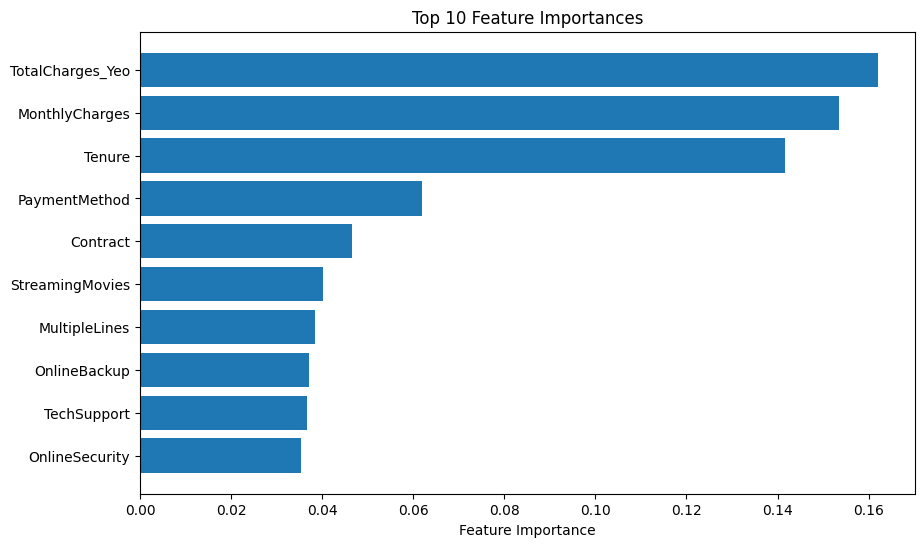

In [43]:
print("Extracting feature importance.")

# Get feature names 
feature_names = x_train.columns.tolist()

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Displaying top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# visualization
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()


In [44]:
# Saving the best Random Forest model
model_filename = 'random_forest_model.pkl'
joblib.dump(best_rf, model_filename)
print(f" Model saved as: {model_filename}")


 Model saved as: random_forest_model.pkl


#### Testing the model

In [45]:
# Input data as dictionary 
input_data = {
    'Gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'Tenure': 30,
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'No',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Bank transfer (automatic)',
    'MonthlyCharges': 69.55,
}
# Creating DataFrame
input_df = pd.DataFrame([input_data])

# Applying label encoding using saved encoders
for col in obj_cols:
    input_df[col] = encoders[col].transform(input_df[col])

# Calculating TotalCharges 
total_charges = input_df['MonthlyCharges'] * input_df['Tenure']
input_df['TotalCharges_Yeo'] = pt.transform(total_charges.values.reshape(-1, 1))

# Reordering columns to match training data
input_df = input_df[x_train.columns]

# Loading the saved model 
model = joblib.load('random_forest_model.pkl')

# Making predictions on new data
predictions = model.predict(input_df)

print("Prediction (Churn=1, No Churn=0):", predictions[0])

Prediction (Churn=1, No Churn=0): 1


C:\Users\ASAD COMPUTERS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Model predicted churn for the  input and when I saw the result from the data, It was same.